In [67]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [68]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
import pandas as pd

In [84]:
# Define paths and parameters
data_dir = r"C:\Users\alian\Downloads\skripshoot\data"
img_height, img_width = 299, 299
batch_size = 32
epochs = 20

In [127]:
from PIL import Image

def rotate_image(image, angle):
    return image.rotate(angle)

def load_and_augment_data(data_dir):
    images = []
    labels = []
    file_paths = []
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
                img = img.resize((img_width, img_height))
                
                # Add original image
                images.append(np.array(img))
                labels.append(0 if class_name == 'non-gingi' else 1)
                file_paths.append(img_path)
                
                # Duplicate image based on rotation
                for angle in [90, 180, 270]:
                    rotated_img = rotate_image(img, angle)
                    images.append(np.array(rotated_img))
                    labels.append(0 if class_name == 'non-gingi' else 1)
                    file_paths.append(img_path)  # Use same path for rotated images
    
    return np.array(images), np.array(labels), np.array(file_paths)

# Use this function instead of the previous load_data function
images, labels, file_paths = load_and_augment_data(data_dir)

In [86]:
print("Training set distribution:", np.bincount(labels))

Training set distribution: [250 276]


In [128]:
datagen = ImageDataGenerator(
    horizontal_flip=True, vertical_flip=True
    )

# Split data
train_val_images, test_images, train_val_labels, test_labels, train_val_paths, test_paths = train_test_split(
    images, labels, file_paths, test_size=0.2)
train_images, val_images, train_labels, val_labels, train_paths, val_paths = train_test_split(
    train_val_images, train_val_labels, train_val_paths, test_size=0.25)

In [111]:
print("Training set distribution:", np.bincount(train_labels))
print("Validation set distribution:", np.bincount(val_labels))
print("Test set distribution:", np.bincount(test_labels))

Training set distribution: [157 158]
Validation set distribution: [54 51]
Test set distribution: [39 67]


In [60]:
# Create data generators
train_generator = datagen.flow(train_images, train_labels, batch_size=batch_size)
val_generator = datagen.flow(val_images, val_labels, batch_size=batch_size)


In [129]:
# Build the model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [130]:
checkpoint = ModelCheckpoint(
    filepath='Inc_data_noaug7030_iter2_weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min',
    verbose=1
)
# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    batch_size=batch_size,
    callbacks=[checkpoint] 
)

Epoch 1/50
10/10 [==============================] - 8s 383ms/step - loss: 0.6360 - accuracy: 0.6413 - val_loss: 0.6645 - val_accuracy: 0.6000
Epoch 2/50
10/10 [==============================] - 3s 293ms/step - loss: 0.1658 - accuracy: 0.9556 - val_loss: 0.7351 - val_accuracy: 0.5714
Epoch 3/50
10/10 [==============================] - 3s 294ms/step - loss: 0.0409 - accuracy: 1.0000 - val_loss: 0.8470 - val_accuracy: 0.5524
Epoch 4/50
10/10 [==============================] - 3s 298ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 0.9864 - val_accuracy: 0.5619
Epoch 5/50
10/10 [==============================] - 3s 294ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.0424 - val_accuracy: 0.6000
Epoch 6/50
10/10 [==============================] - 3s 291ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.9954 - val_accuracy: 0.5714
Epoch 7/50
10/10 [==============================] - 3s 289ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.8372 - val_accuracy: 0.6286
Epoch 

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Print final training and validation metrics
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")




4/4 [==============================] - 0s 94ms/step
Unique values in test_labels: [0 1]
Unique values in predicted_classes: [0 1]


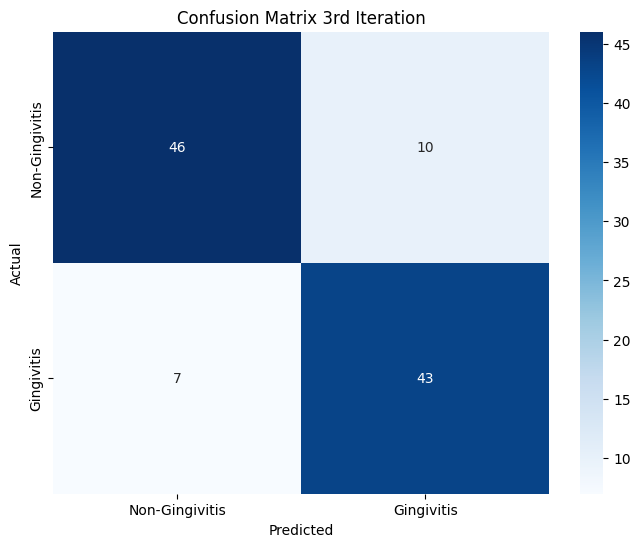

                precision    recall  f1-score   support

Non-Gingivitis       0.87      0.82      0.84        56
    Gingivitis       0.81      0.86      0.83        50

      accuracy                           0.84       106
     macro avg       0.84      0.84      0.84       106
  weighted avg       0.84      0.84      0.84       106



In [132]:
# Evaluate the model
model.evaluate(test_images, test_labels, batch_size=batch_size)
# print(f"Test accuracy: {test_accuracy:.4f}")

# Generate predictions
predictions = model.predict(test_images, batch_size=batch_size)
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)

# The rest of your code remains the same
print("Unique values in test_labels:", np.unique(test_labels))
print("Unique values in predicted_classes:", np.unique(predicted_classes))

labels = sorted(np.unique(np.concatenate([test_labels, predicted_classes])))
target_names = ['Non-Gingivitis' if l == 0 else 'Gingivitis' for l in labels]

cm = confusion_matrix(test_labels, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix 3rd Iteration')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(test_labels, predicted_classes, labels=labels, target_names=target_names, zero_division=1))

In [ ]:
# Model evaluation using new data testing
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the path to your test data folder
test_data_dir = r'C:\Users\alian\Downloads\skripshoot\test data'

# Function to load images from a directory
def load_images_from_directory(directory, target_size=(299, 299)):
    images = []
    labels = []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                img = load_img(img_path, target_size=target_size)
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(0 if class_name == 'non-gingi' else 1)
    return np.array(images), np.array(labels)

# Load test images and labels
test_images, test_labels = load_images_from_directory(test_data_dir)


# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels, batch_size=batch_size)
print(f"Test accuracy: {test_accuracy:.4f}")

# Generate predictions
predictions = model.predict(test_images, batch_size=batch_size)
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)

# The rest of your code remains the same
print("Unique values in test_labels:", np.unique(test_labels))
print("Unique values in predicted_classes:", np.unique(predicted_classes))

labels = sorted(np.unique(np.concatenate([test_labels, predicted_classes])))
target_names = ['Non-Gingivitis' if l == 0 else 'Gingivitis' for l in labels]

cm = confusion_matrix(test_labels, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix 1st Iteration')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(test_labels, predicted_classes, labels=labels, target_names=target_names, zero_division=1))